In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
#import bambi as bmb
import xarray as xr
import random
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('paper')
sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
with matplotlib.style.context('arviz-doc'):
    az_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.set_palette(az_colors)

def origo(ax=None):
    if ax is None:
        ax = plt.gca()
    x, y = ax.get_xlim(), ax.get_ylim()
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    plt.ylim(min(0, miny), max(0, maxy))
    plt.xlim(min(0, minx), max(0, maxx))

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)

from math import sqrt
from itertools import zip_longest
#from IPython.display import HTML
from IPython.core.display import HTML
class cols:
    def __rlshift__(self, words):
        ""
        ncols = None
        n = len(words)
        col_width = max(map(len, words)) + 3
        if ncols is None:
            # if col_width * n < 300:
            #     ncols = 1
            # else:
            ncols = min(200//col_width, 1+sqrt(n/col_width))
        nrows = int(n/ncols) + 1
        rows = []
        if True:
            for r in range(0, n, nrows):
                rows.append(words[r:r+nrows])
            table = ['<table>']
            for row in list(zip_longest(*rows, fillvalue='')):
                table.append('<tr style="background-color:#ffffff">')
                for gene in row:
                    table.append(f'<td style="text-align:left;padding-right:30px;padding-bottom:5px">{gene}</td>')
                table.append('</tr>')
            table.append('</table>')
            return HTML(''.join(table))
        else:
            for r in range(0, n, nrows):
                rows.append(words[r:r+nrows])
            for row in list(zip_longest(*rows, fillvalue='')):
                line = []
                for gene in row:
                    line.append(gene.ljust(col_width))
                print(''.join(line))

In [2]:
# scale = 0.35
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context().items() if v is not None])
# d['figure.figsize'] = [1.8, 1.3]
# matplotlib.rcParams.update(d)
# make context for with statement:
# #matplotlib.style.context(d)

In [3]:
# plt.plot(np.random.random(10), np.random.random(10)-10)
# origo()

In [4]:
#Disable annoying "UserWarning: The figure layout has changed to tight" message
import warnings
warnings.filterwarnings('ignore', category=UserWarning
                        # , module='seaborn'
                       )
warnings.filterwarnings('ignore', category=FutureWarning,
                        # module='matplotlib'
                       )

# Read in data

In [5]:
def read_data(file_name):
    df = pd.read_csv(file_name)
    df['haplotype'] = [f'{x}_{y}' for (x, y) in zip(df.individual, df.haplotype)]
    population, country = list(zip(*[x.split(', ') for x in df.Origin]))
    df['population'] = population
    df['country'] = country
    return df

if False:
    (pd.concat([read_data('~/baboondiversity/people/eriks/second_analysis_baboons/data/chrX_diversity_admixture.txt'),
                read_data('~/baboondiversity/people/eriks/second_analysis_baboons/data/autosome_diversity_admixture.txt')]
              )
     .to_hdf('data.h5', key='df')
    )
else:  
    df = pd.read_hdf('data.h5')
df.head()

,chrom,start,diversity,individual,haplotype,end,north_sum,Origin,Sex,population,country
0,chrX,0,0.001997,PD_0199,PD_0199_0,100000,0,"Serengeti, Tanzania",F,Serengeti,Tanzania
1,chrX,0,0.001997,PD_0199,PD_0199_1,100000,0,"Serengeti, Tanzania",F,Serengeti,Tanzania
2,chrX,0,0.001997,PD_0200,PD_0200_0,100000,0,"Serengeti, Tanzania",F,Serengeti,Tanzania
3,chrX,0,0.001997,PD_0200,PD_0200_1,100000,0,"Serengeti, Tanzania",F,Serengeti,Tanzania
4,chrX,0,0.001997,PD_0201,PD_0201_0,100000,0,"Serengeti, Tanzania",M,Serengeti,Tanzania


In [6]:
df.population.unique().tolist() << cols()

Serengeti,Selous
Arusha,Lake Manyara
Ngorongoro,Tarangire
Ruaha,Mikumi
Gombe,Issa Valley
Udzungwa,Gog Woreda
Mahale,Aberdare
Katavi,


In [7]:
#data = df.copy().loc[(df.chrom == 'chr20') & (df.population.isin(
data = df.copy().loc[(df.chrom != 'chrX') & (df.population.isin(
    [
        'Serengeti','Ngorongoro', 'Lake Manyara', 'Tarangire',
#         'Arusha', 'Aberdare', 
#        'Ruaha', 'Gombe', 'Gog Woreda', 
        # 'Udzungwa', 'Mahale', 'Katavi', 'Selous', 'Mikumi', 'Issa Valley',
    ]))]
data['pop_mean_north_sum'] = data.groupby('population').north_sum.transform('mean')

data.population.unique().tolist()

['Serengeti', 'Ngorongoro', 'Lake Manyara', 'Tarangire']

Numbers of samples:

In [8]:
data[['population', 'haplotype']].drop_duplicates().groupby('population').haplotype.agg('size')

population
Lake Manyara    38
Ngorongoro      12
Serengeti       28
Tarangire       14
Name: haplotype, dtype: int64

In [9]:
data.tail()

,chrom,start,diversity,individual,haplotype,end,north_sum,Origin,Sex,population,country,pop_mean_north_sum
7680658,chr9,125700000,0.002072,PD_0684,PD_0684_1,125800000,84130,"Lake Manyara, Tanzania",NaN,Lake Manyara,Tanzania,94935.388054
7680659,chr9,125700000,0.002072,PD_0685,PD_0685_0,125800000,84130,"Lake Manyara, Tanzania",NaN,Lake Manyara,Tanzania,94935.388054
7680660,chr9,125700000,0.002072,PD_0685,PD_0685_1,125800000,84130,"Lake Manyara, Tanzania",NaN,Lake Manyara,Tanzania,94935.388054
7680661,chr9,125700000,0.002072,PD_0686,PD_0686_0,125800000,84130,"Lake Manyara, Tanzania",NaN,Lake Manyara,Tanzania,94935.388054
7680662,chr9,125700000,0.002072,PD_0686,PD_0686_1,125800000,84130,"Lake Manyara, Tanzania",NaN,Lake Manyara,Tanzania,94935.388054


In [ ]:
sns.lmplot(data=data, x="north_sum", y="diversity", hue="population", scatter=False, lowess=True)

/home/kmt/miniconda3/envs/pymc/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/kmt/miniconda3/envs/pymc/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [ ]:
sns.lmplot(data=data.loc[(data.population == 'Lake Manyara') & (data.north_sum > 60000)], x="north_sum", y="diversity", hue="individual", scatter=False);


In [ ]:
sns.lmplot(data=data.loc[(data.population == 'Serengeti') & (data.north_sum > 60000)], x="north_sum", y="diversity", hue="individual", scatter=False);


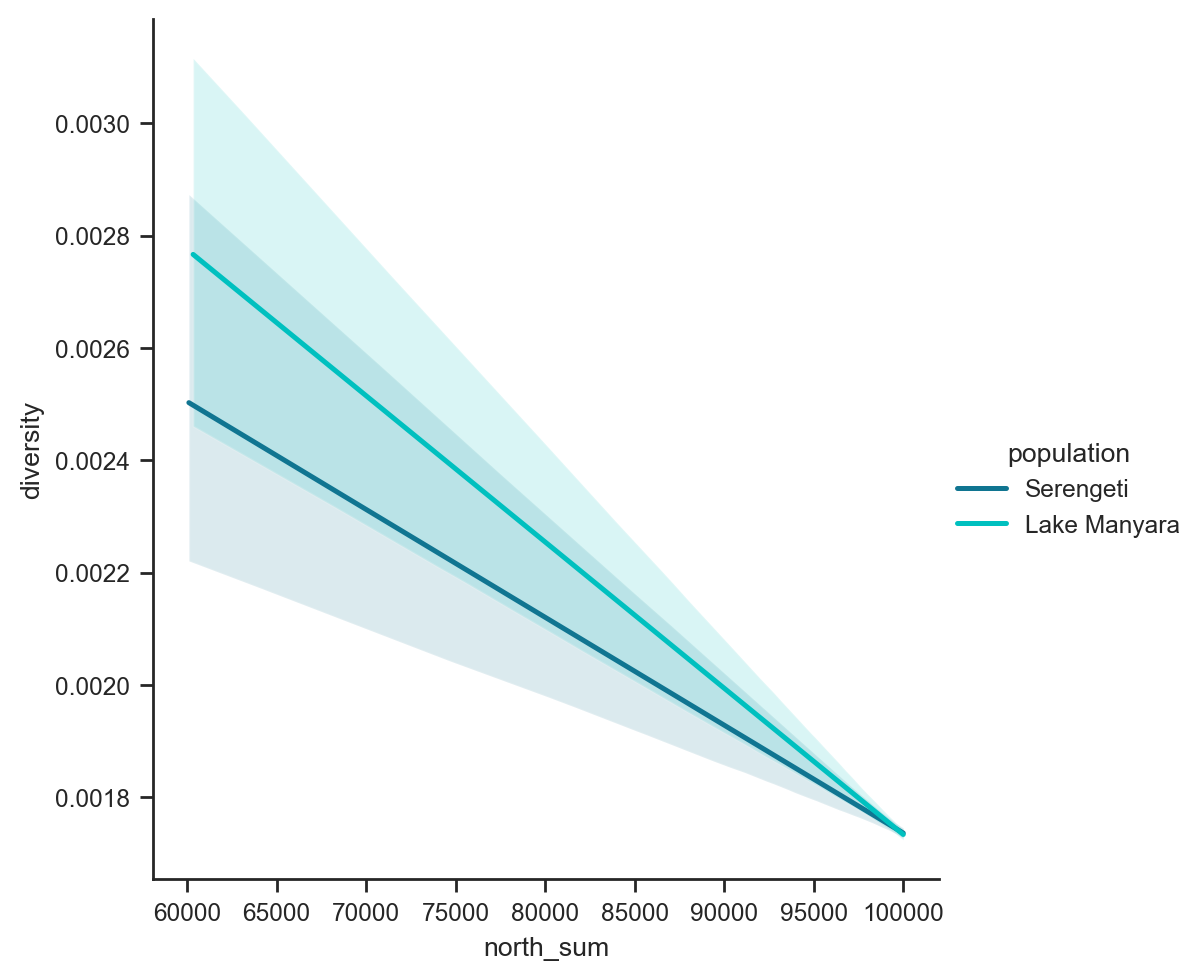

In [47]:
sns.lmplot(data=data.loc[(data.haplotype.isin(['PD_0200_0', 'PD_0686_1'])) & (data.north_sum > 60000)], x="north_sum", y="diversity", hue="population", scatter=False)

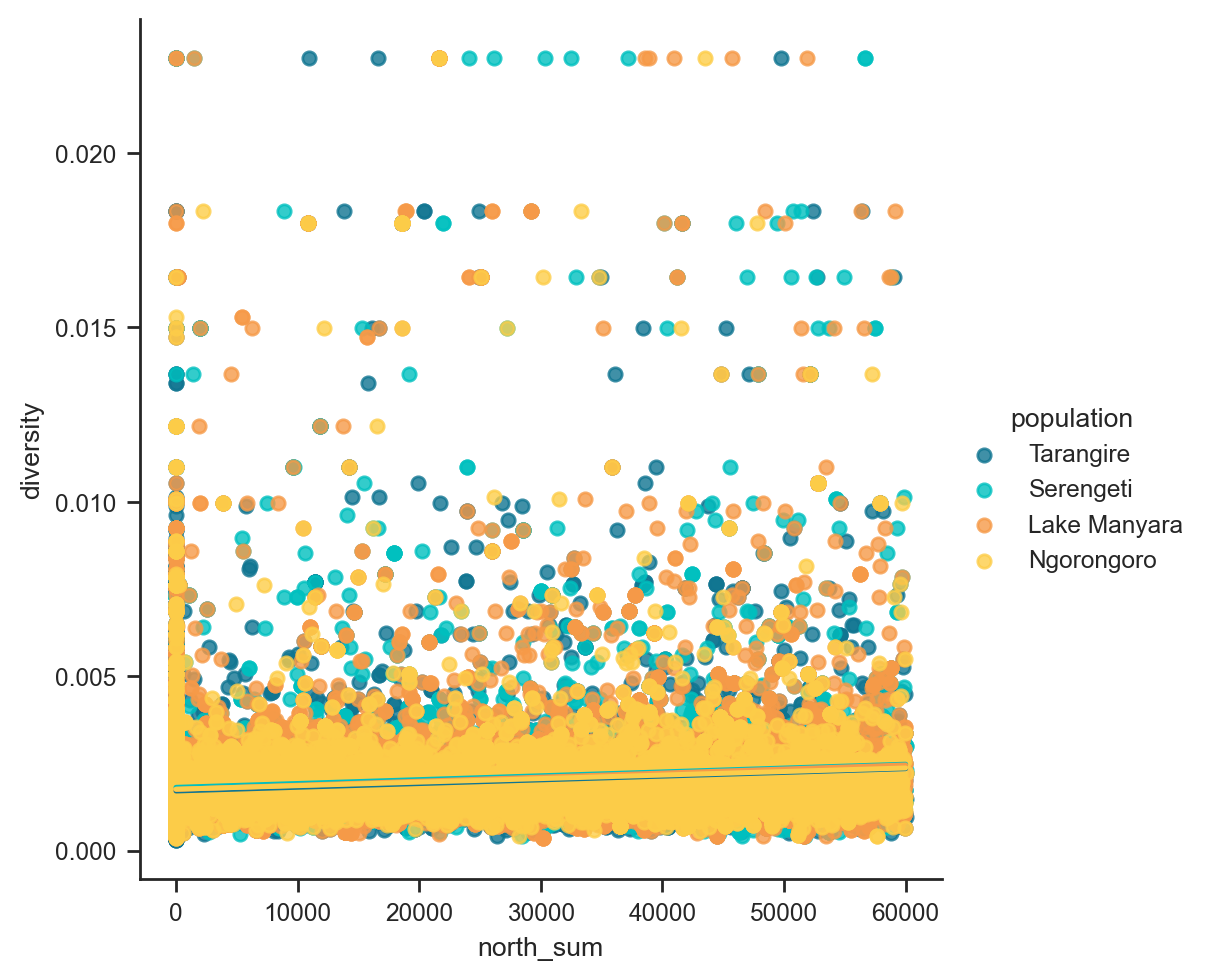

In [41]:
sns.lmplot(data=data.loc[data.north_sum < 60000], x="north_sum", y="diversity", hue="population", scatter=False)

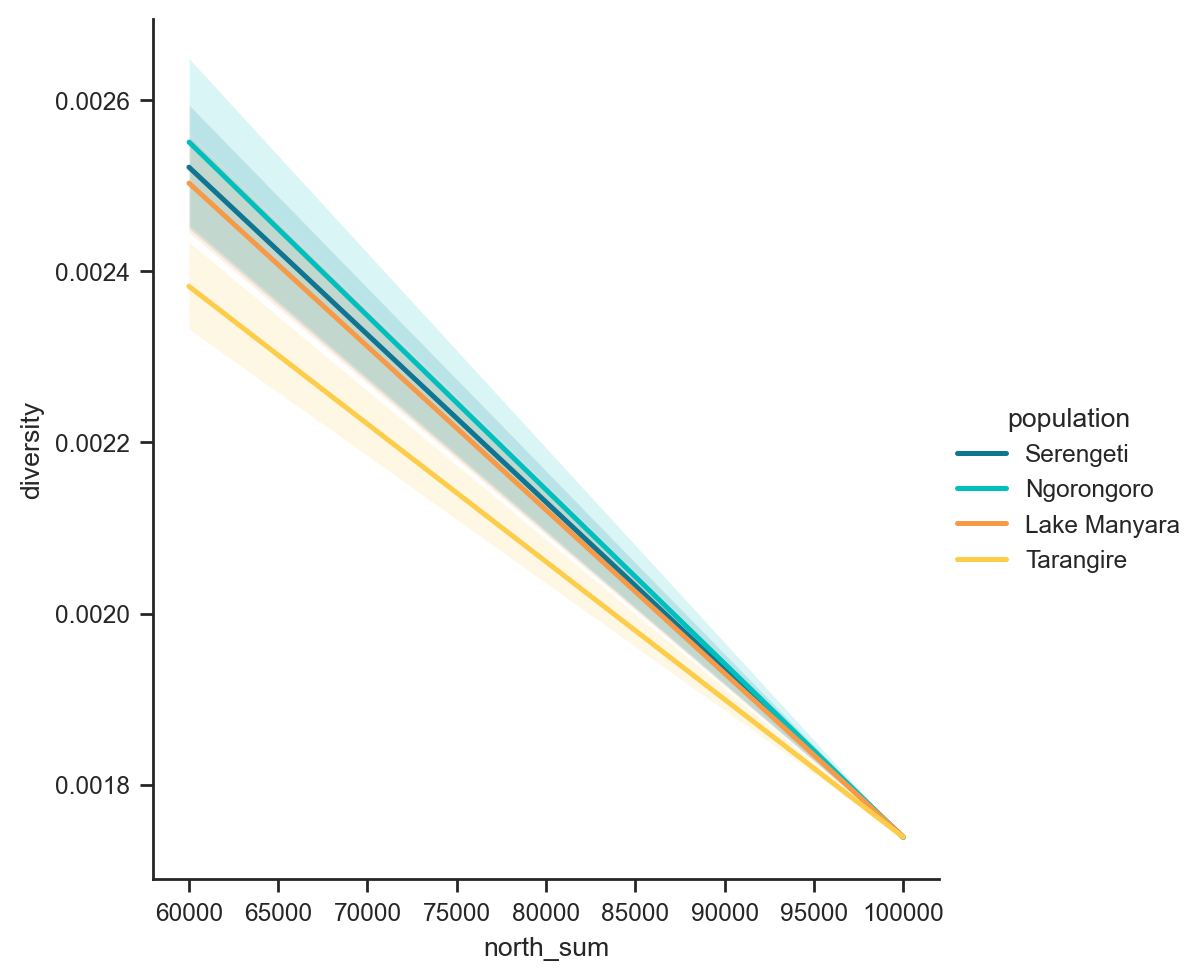

In [38]:
sns.lmplot(data=data.loc[data.north_sum > 60000], x="north_sum", y="diversity", hue="population", scatter=False)

In [15]:
data.groupby(['population']).north_sum.mean()

population
Lake Manyara    94935.388054
Ngorongoro      94749.496147
Serengeti       96511.223770
Tarangire       79001.909892
Name: north_sum, dtype: float64

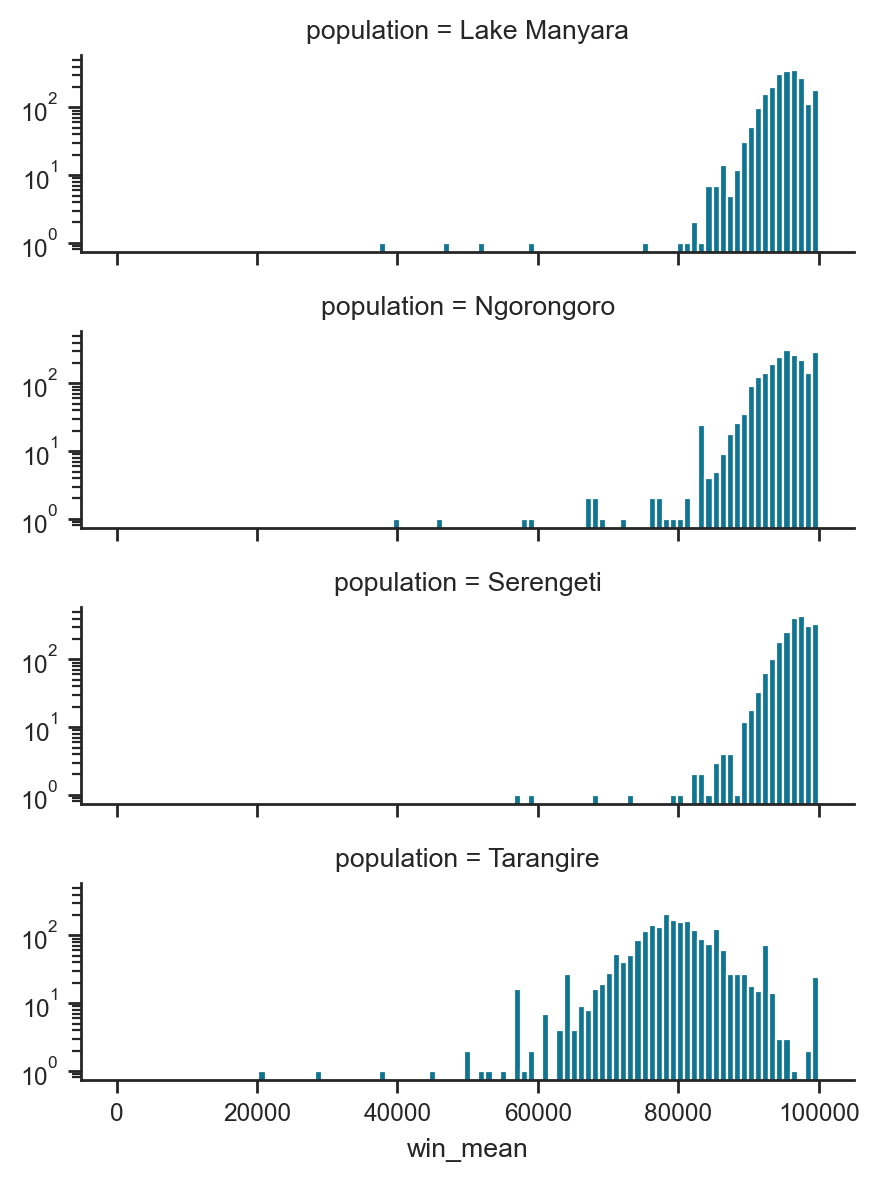

In [33]:
plot_df = data.groupby(['start', 'population']).north_sum.mean().to_frame('win_mean').reset_index()
g = sns.FacetGrid(data=plot_df, row='population', height=1.5, aspect=3)
g.map(plt.hist, 'win_mean', bins=np.linspace(0, 100000, 100));
plt.yscale('log')

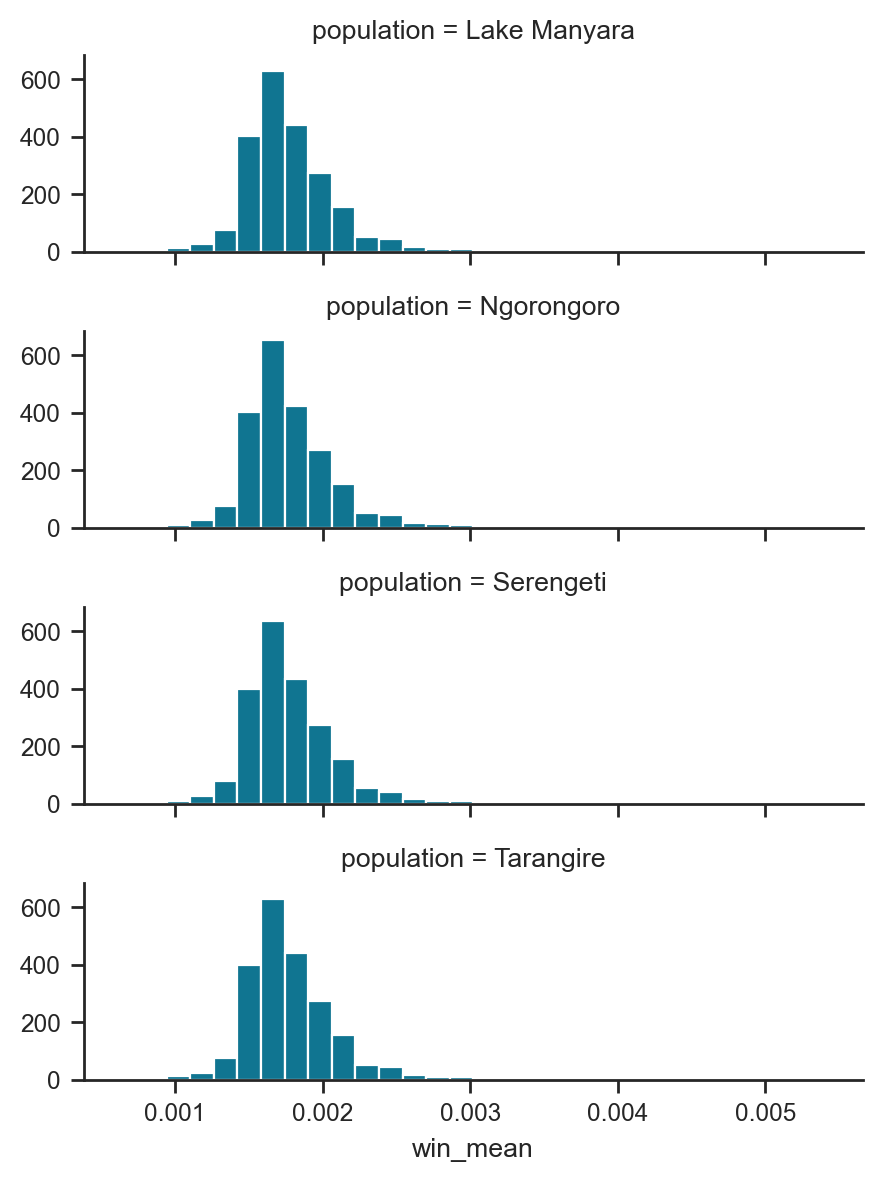

In [17]:
plot_df = data.groupby(['start', 'population']).diversity.mean().to_frame('win_mean').reset_index()
g = sns.FacetGrid(data=plot_df, row='population', height=1.5, aspect=3)
g.map(plt.hist, 'win_mean', bins=30);

In [18]:
selected_groups = ['Serengeti','Ngorongoro', 'Lake Manyara', 'Tarangire']

# Transform data

In [19]:
species_encoder = LabelEncoder()

gr = data.groupby('population')

df = pd.DataFrame(dict(
    
    # log scale and z transform population mean north globally
    pop_mean_north_sum = data.pop_mean_north_sum.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # log scale and z transform north_sum rate by population
    north_sum = gr.north_sum.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # z transform diversity by population
    diversity = gr.diversity.transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # population name for each observation
    population = data.population,

    # population to integer transform
    population_index = species_encoder.fit_transform(data.population)
    
))
df.head()

,pop_mean_north_sum,north_sum,diversity,population,population_index
0,0.579178,0.252665,1.69416,Serengeti,2
1,0.579178,0.252665,1.69416,Serengeti,2
2,0.579178,0.252665,1.69416,Serengeti,2
3,0.579178,0.252665,1.69416,Serengeti,2
4,0.579178,0.252665,1.69416,Serengeti,2


# Observations

In [20]:
window_y_values = df.diversity.values
window_x_values = df.north_sum.values
global_group_names = pd.unique(species_encoder.inverse_transform(df.population_index))
global_group_indices = df.population_index
global_group_values = df[['population', 'pop_mean_north_sum']].drop_duplicates().pop_mean_north_sum.values

assert len(global_group_names) == len(global_group_values)
assert len(window_y_values) == len(window_x_values)
assert len(window_x_values) == len(global_group_indices)

# Hierarchical model

In [21]:
model_hierarchical = pm.Model(coords = {"global_group": global_group_names,
                           "obs_id": np.arange(len(window_x_values))})
non_centered = True

with model_hierarchical:
    # data
    window_dependent = pm.ConstantData('window_dependent', window_x_values, dims='obs_id')
    window_independent = pm.ConstantData('window_independent', window_y_values, dims='obs_id')
    global_group_member = pm.ConstantData('global_group_member', global_group_indices, dims='obs_id')
    global_dependent =  pm.ConstantData('global_dependent', global_group_values, dims='global_group')

    # hyperprior on window_independent ~ window_dependent intercept prior
    hyp_inter_inter = pm.Normal("hyp_inter_inter", mu=0, sigma=1)
    hyp_inter_slope = pm.Normal("hyp_inter_slope", mu=0, sigma=1)
    
    # hyperprior on window_independent ~ window_dependent slope prior
    hyp_slope_inter = pm.Normal("hyp_slope_inter", mu=0, sigma=1)
    hyp_slope_slope = pm.Normal("hyp_slope_slope", mu=0, sigma=1)

    # prior on residual variation on global_group intercepts
    group_inter_residual = pm.Normal("group_inter_residual", 0, sigma=1, dims="global_group")
    
    # prior on residual variation on global_group slopes
    group_slope_residual = pm.Normal("group_slope_residual", 0, sigma=1, dims="global_group")

    # prior on window_independent ~ window_dependent intercept for each global_group
    mu_inter = hyp_inter_inter + hyp_inter_slope * global_dependent
    sigma_inter = pm.Exponential("sigma_inter", 1)
    group_inter = pm.Deterministic("group_inter", mu_inter + group_inter_residual * sigma_inter, dims="global_group")

    # prior on window_independent ~ window_dependent slope for each global_group
    mu_slope = hyp_slope_inter + hyp_slope_slope * global_dependent
    sigma_slope = pm.Exponential("sigma_slope", 1)
    group_slope = pm.Deterministic("group_slope", mu_slope + group_slope_residual * sigma_slope, dims="global_group")
        
    # prior window_independent ~ window_dependent slope for each global_group
    mu_window_independent = group_inter[global_group_member] + group_slope[global_group_member] * window_dependent
    sigma_window_independent = pm.Exponential("sigma_window_independent", 0.01)

    # prior
    WindowIndependent = pm.Normal("Independent", mu=mu_window_independent, sigma=sigma_window_independent, observed=window_independent, dims="obs_id")

In [22]:
%%capture
fig, ax = plt.subplots()
g = pm.model_to_graphviz(model_hierarchical)
g.graph_attr.update(size="10,10")

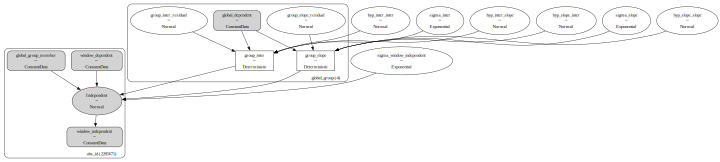

In [23]:
g

## Prior predictive checks

In [24]:
with model_hierarchical:
    idata_hierarchical = pm.sample_prior_predictive()

Sampling: [Independent, group_inter_residual, group_slope_residual, hyp_inter_inter, hyp_inter_slope, hyp_slope_inter, hyp_slope_slope, sigma_inter, sigma_slope, sigma_window_independent]


In [25]:
prior = idata_hierarchical.prior.squeeze(drop=True)

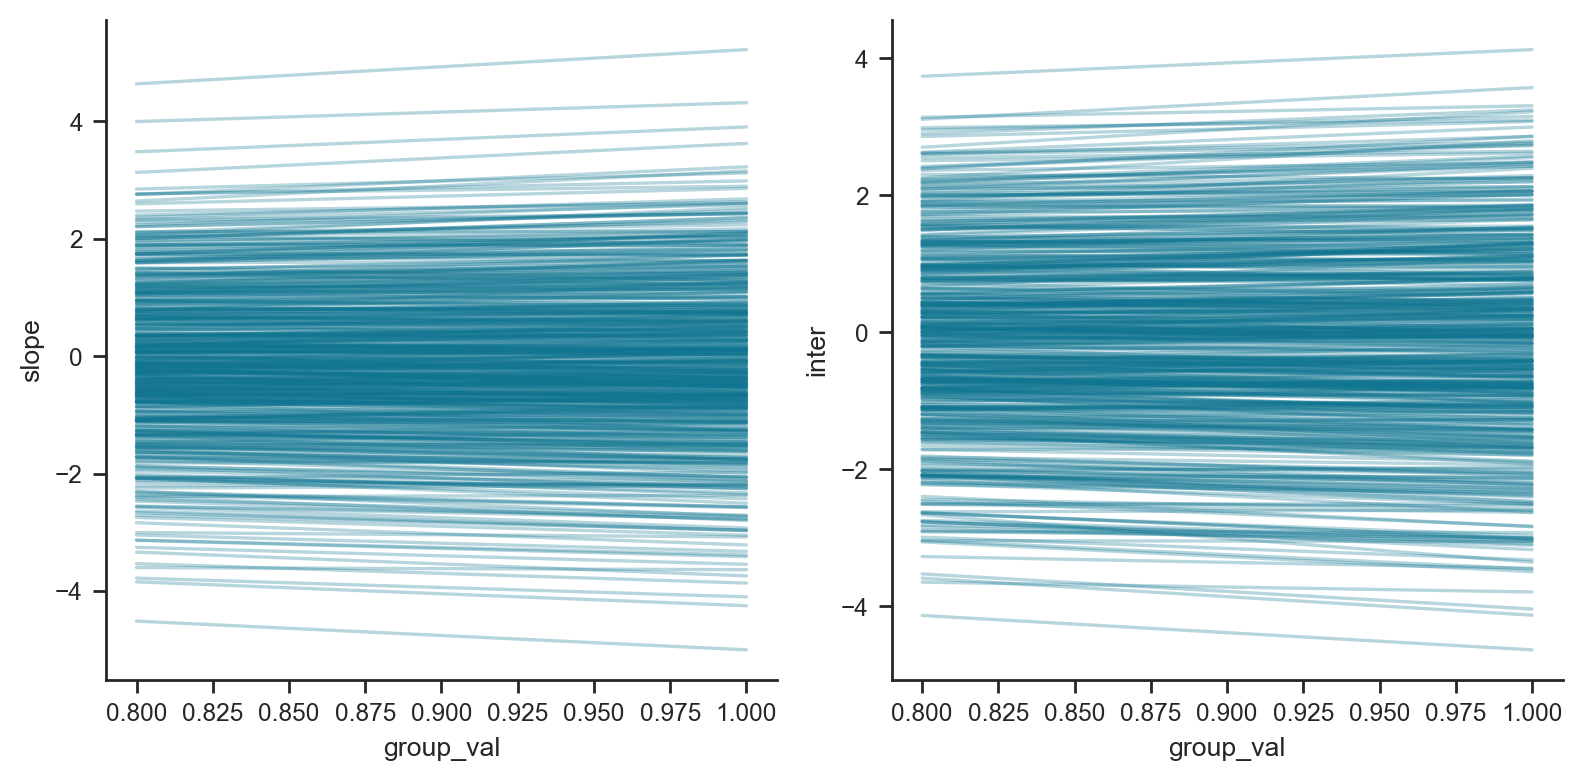

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(0.8, 1, 200), dims=["plot_dim"])
prior = idata_hierarchical.prior

slope = prior["hyp_slope_inter"] + prior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = prior["hyp_inter_inter"] + prior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax2.set_xlabel("group_val")
ax2.set_ylabel("inter")
plt.tight_layout()

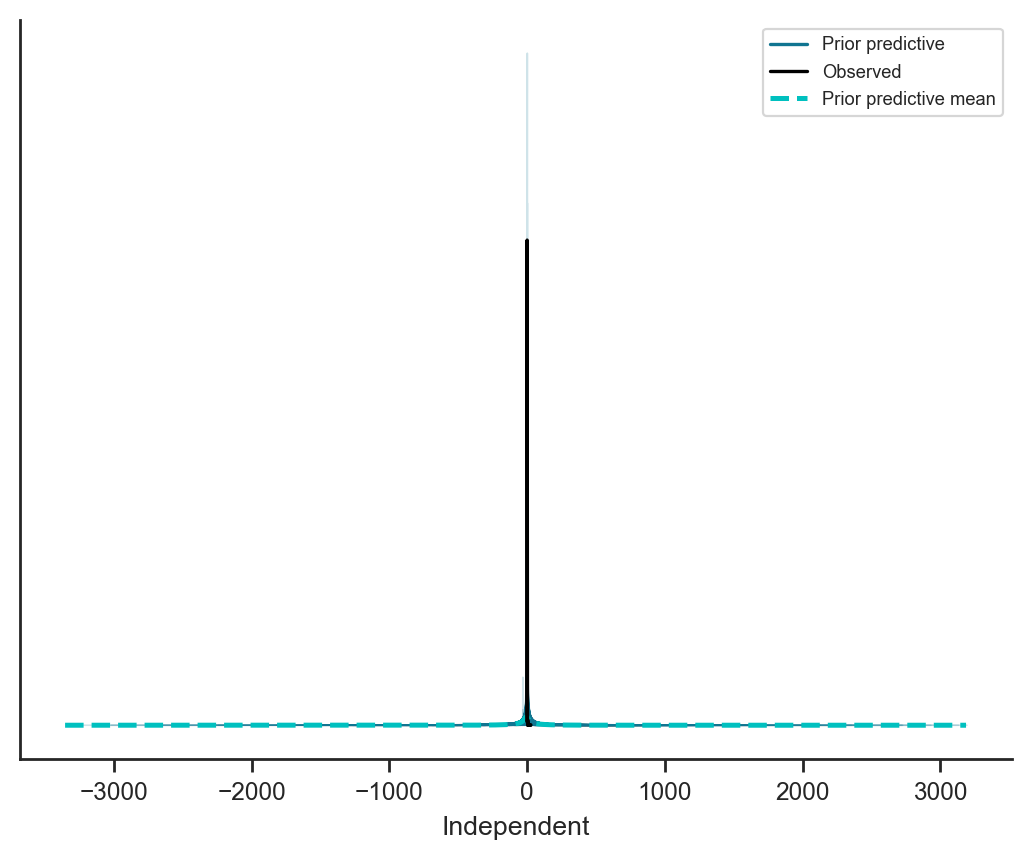

In [27]:
az.plot_ppc(idata_hierarchical, group='prior') ;

## Model trace

In [28]:
use_cached = True

trace_file = 'baboon_hierarchical.nc'
if use_cached and os.path.exists(trace_file):
    with model_hierarchical:
         trace = az.from_netcdf(trace_file)
else:
    with model_hierarchical:
        trace = pm.sample(#1000, 
                          target_accept=0.95, 
                          return_inferencedata=True,
                          progressbar=True, 
            # cores=4, chains=4
        )
        trace.to_netcdf(trace_file)

idata_hierarchical.extend(trace)


## Trace diagnostics

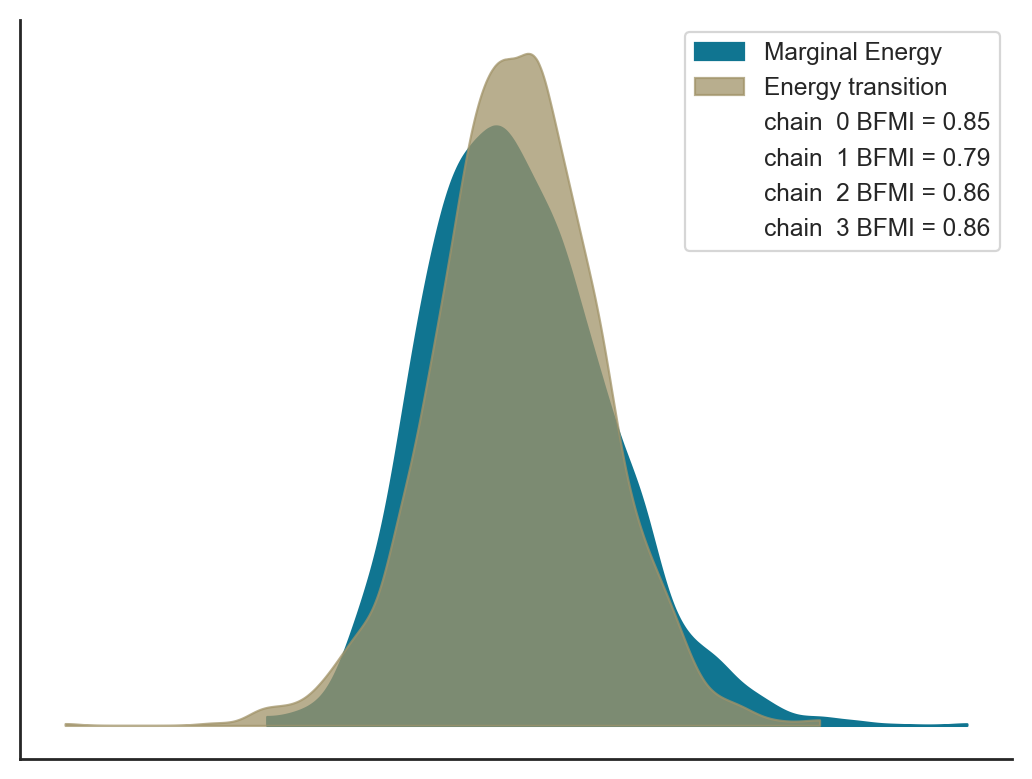

In [29]:
az.plot_energy(idata_hierarchical);

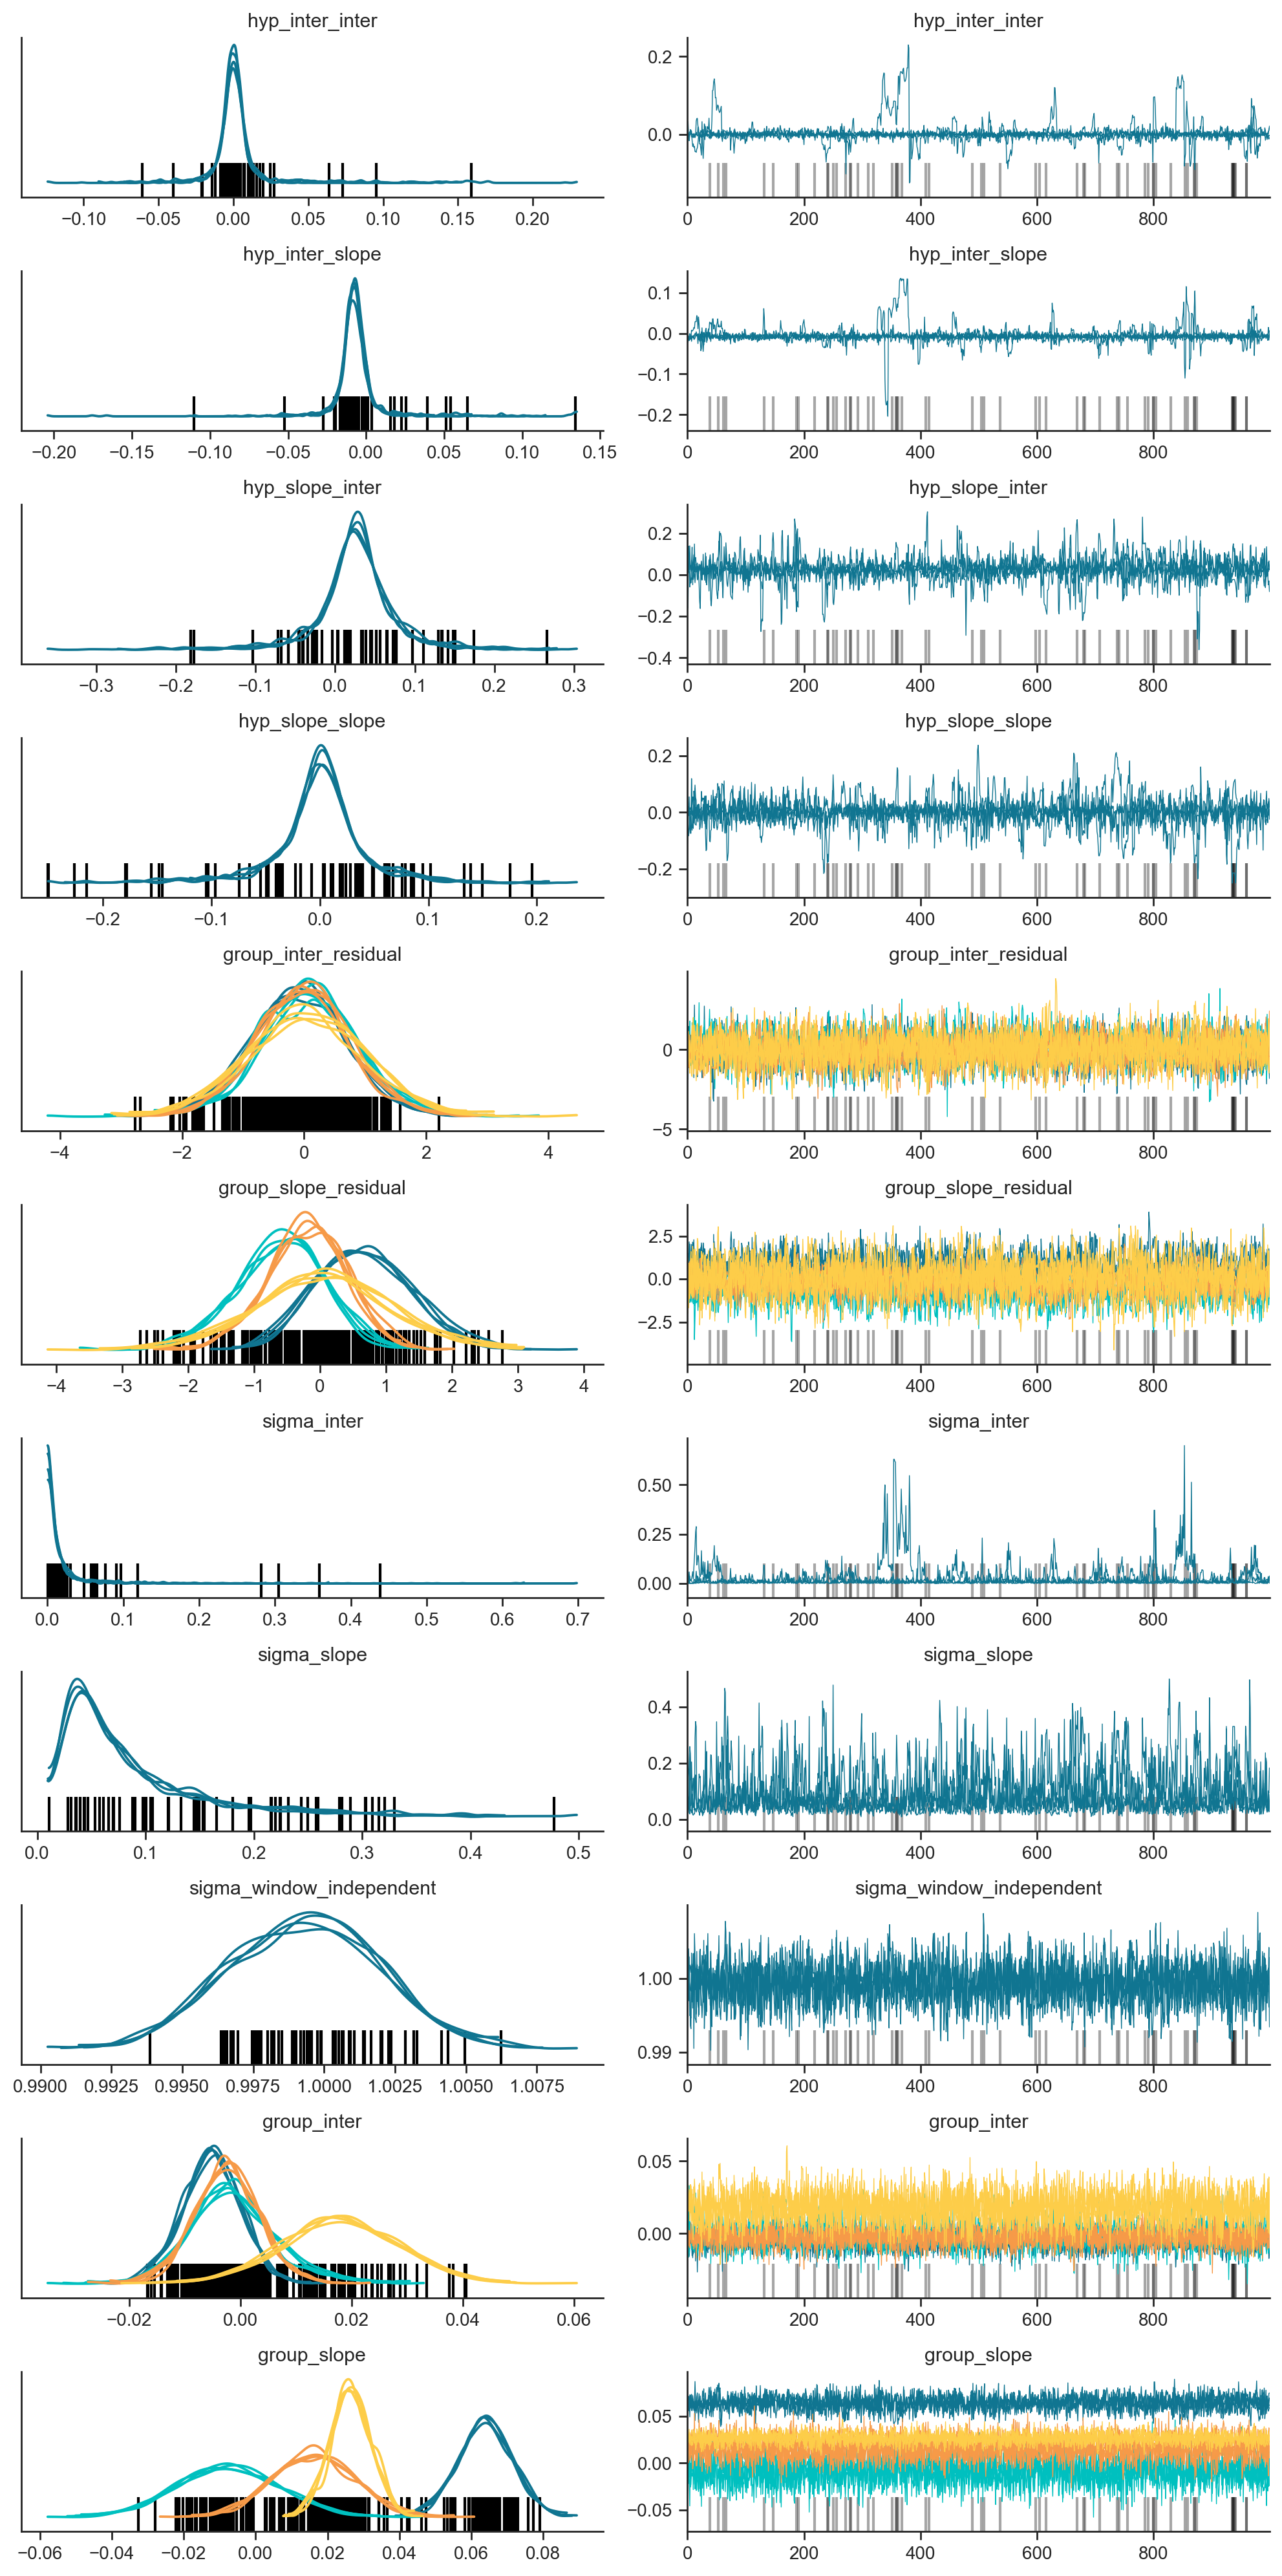

In [30]:
az.plot_trace(idata_hierarchical,
    # var_names=[],
    compact=True,
    figsize=(10, 20),
    chain_prop=dict(linestyle='-'),
    trace_kwargs=dict(linestyle='-', linewidth=0.5, alpha=1),
             )
plt.tight_layout()

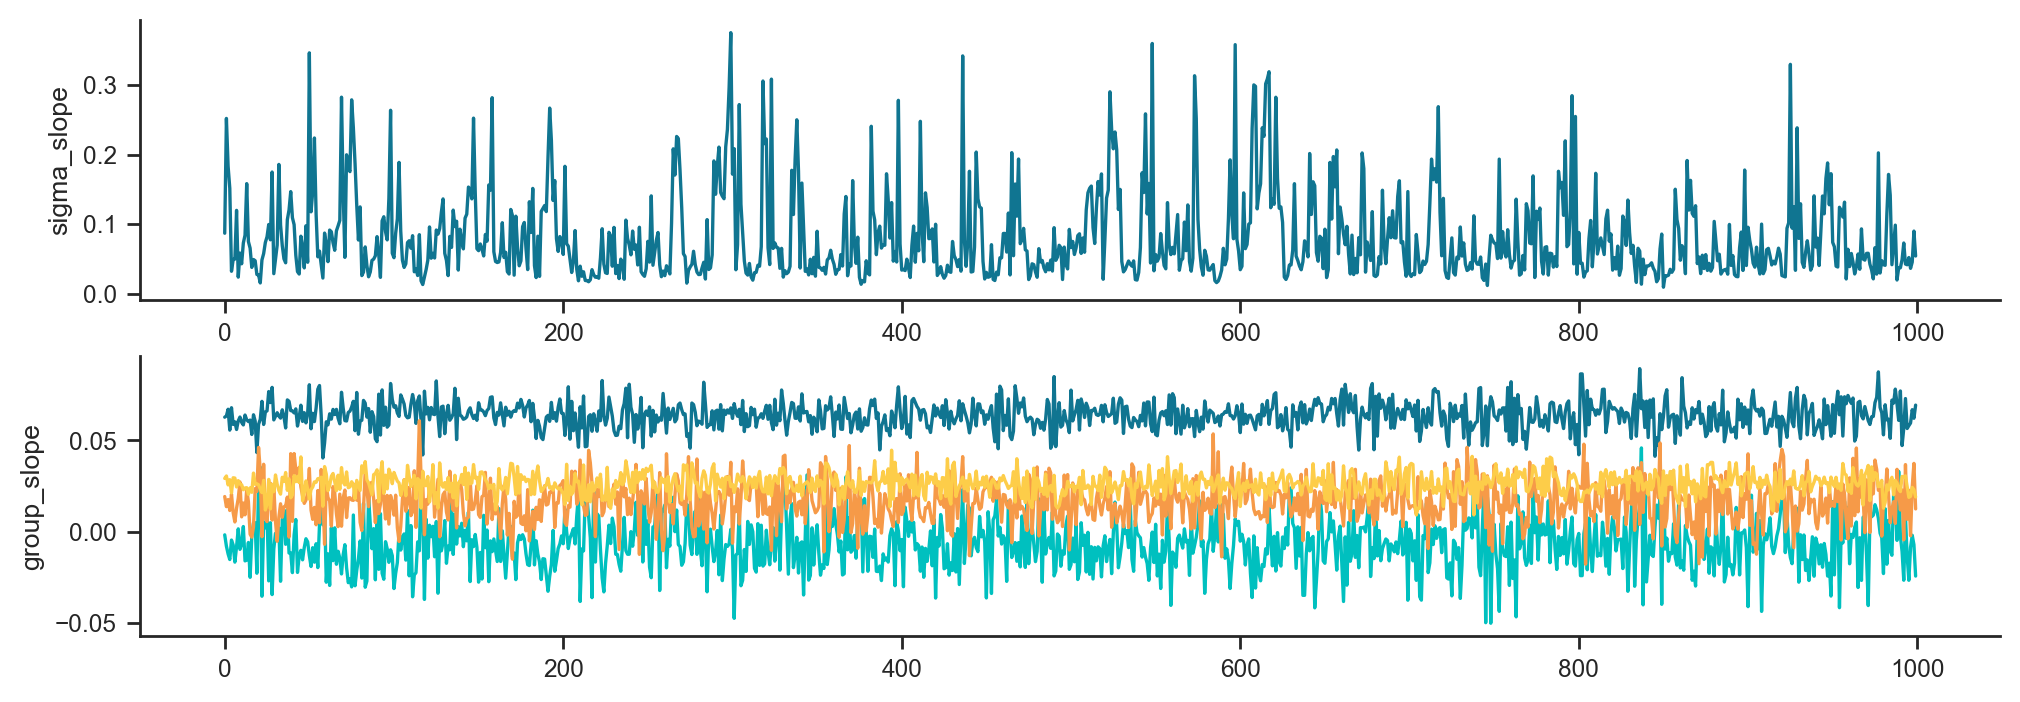

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(12,  4))
axs[0].plot(idata_hierarchical.posterior.sel(chain=0)["sigma_slope"])
axs[0].set(ylabel="sigma_slope")
axs[1].plot(idata_hierarchical.posterior.sel(chain=0)["group_slope"])
axs[1].set(ylabel="group_slope");

In [32]:
ax = az.plot_pair(
    idata_hierarchical,
    var_names=["group_slope", "sigma_slope"],
    coords=dict(global_group=selected_groups[0]),
    marginals=True,d
    #marginal_kwargs={"kind": "hist"},
)
#ax[1, 0].set_title(selected_groups[1])

SyntaxError: positional argument follows keyword argument (37231934.py, line 7)

## Posterior predictive checks

In [ ]:
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to sample_posterior_predictive
thinned_idata = idata_hierarchical.sel(draw=slice(None, None, 5))
with model_hierarchical:
    idata_hierarchical.extend(pm.sample_posterior_predictive(thinned_idata))

# # generate 5 posterior predictive samples per posterior sample
# expanded_data = idata_hierarchical.posterior.expand_dims(pred_id=5)
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(expanded_data))

In [ ]:
#idata_hierarchical.to_netcdf('idata_hierarchical.nc')

In [ ]:
#idata_hierarchical = az.from_netcdf('idata_hierarchical.nc')

In [ ]:
az.summary(idata_hierarchical, round_to=4)

In [ ]:
post_mean = idata_hierarchical.posterior.mean(dim=("chain", "draw"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
posterior = idata_hierarchical.posterior

slope = posterior["hyp_slope_inter"] + posterior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax1.plot(group_val, post_mean["hyp_slope_inter"] + post_mean["hyp_slope_slope"] * group_val, c="C2")
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = posterior["hyp_inter_inter"] + posterior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax2.plot(group_val, post_mean["hyp_inter_inter"] + post_mean["hyp_slope_inter"] * group_val, c="C2")
ax2.set_xlabel("group_val")
ax2.set_ylabel("intercept")
plt.tight_layout()

In [ ]:
ax = pm.plot_forest(
    idata_hierarchical,
    var_names=["group_slope", "hyp_slope_slope", "hyp_slope_inter"],
    figsize=(6, 3),
    combined=True,
    r_hat=True,
    # backend_kwargs={'font' : {'family' : 'normal',
    #     'weight' : 'bold',
    #     'size'   : 22}},
    # labeller=az.labels.NoVarLabeller(),
)
#ax[0].set_yticks(fontsize=20)
#ax[0].set_ylabel("alpha")

In [ ]:
pm.plot_posterior(idata_hierarchical, var_names=["hyp_slope_slope", "hyp_slope_inter"],
#                  coords={"global_group" : selected_groups}, 
                  figsize=(8, 3));

In [ ]:
selected_groups

In [ ]:
az.plot_dist_comparison(idata_hierarchical, var_names=["hyp_slope_slope", "hyp_slope_inter"], 
                        coords={"global_group" : selected_groups},
                        figsize=(8, 6))
plt.tight_layout()

In [ ]:
obs_group = idata_hierarchical.posterior["global_group"][idata_hierarchical.constant_data["global_group_member"]]
_idata = idata_hierarchical.assign_coords(obs_id=obs_group, groups="observed_vars")
#_idata = idata.assign_coords(obs_id=obs_group)
az.plot_ppc(_idata, group='posterior', 
            coords={'obs_id': selected_groups}, 
            flatten=[], figsize=(9, 4)) ;

In [ ]:
# az.plot_ppc(_idata, group='posterior', flatten=[], figsize=(15, 10))
# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

In [ ]:
az.plot_bpv(idata_hierarchical) ;

In [ ]:
az.plot_bpv(idata_hierarchical, kind="p_value") ;

In [ ]:
az.plot_bpv(idata_hierarchical, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1)) ;

In [ ]:
for p in ['hyp_inter_inter', 'hyp_inter_slope', 'hyp_slope_inter', 'hyp_slope_slope', 'group_inter_residual',
          'group_slope_residual', 'sigma_inter', 'sigma_slope', 'sigma_window_independent']:
    idata_hierarchical.posterior[p].to_dataframe().to_hdf(f"{p}.h5", key='df')

# Model performance

**Leave-one-out Cross-validation (LOO)**

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

**Widely-applicable Information Criterion (WAIC)**

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

By default ArviZ uses LOO, but WAIC is also available.

**Model log-likelihood**

In order to compute LOO and WAIC, ArviZ needs access to the model elemwise loglikelihood for every posterior sample. We can add it via compute_log_likelihood(). Alternatively we can pass idata_kwargs={"log_likelihood": True} to sample() to have it computed automatically at the end of sampling.

## Model likelihood

In [ ]:
# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to compute_log_likelihood
thinned_idata = idata_hierarchical.sel(draw=slice(None, None, 5))
with model_hierarchical:
    idata_hierarchical.extend(pm.compute_log_likelihood(thinned_idata))

## Loo ELPD

arviz docs: https://python.arviz.org/en/stable/api/generated/arviz.loo.html

Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO’s standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

Compute elemwise log_likelihood of model given InferenceData with posterior group:

In [ ]:
loo_hierarchical = az.loo(idata_hierarchical)
loo_hierarchical

In [ ]:
loo_pointwise_hierarchical = az.loo(idata_hierarchical, pointwise=True)
loo_hierarchical

Save as pandas series:

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    loo_hierarchical.to_hdf('loo_hierarchical.h5', key='df')
    loo_pointwise_hierarchical.to_hdf('loo_pointwise_hierarchical.h5', key='df')    

Turn back into arviz `ELPDData`:

In [ ]:
from arviz.stats import ELPDData
loo_hierarchical = ELPDData(pd.read_hdf('loo_hierarchical.h5'))
loo_hierarchical

## Khat

Plot Pareto tail indices for khat diagnosing convergence in PSIS-LOO:

In [ ]:
az.plot_khat(loo_pointwise_hierarchical, show_bins=True, figsize=(12, 4)) ;

In [ ]:
az.plot_khat(loo_pointwise_hierarchical.pareto_k, xlabels=True, threshold=1)

In [ ]:
# counties = radon.posterior.County[radon.constant_data.county_idx].values
# colors = [
#     "blue" if county[-1] in ("A", "N") else "green" for county in counties
# ]
# az.plot_khat(loo_radon, color=colors)

In [ ]:
groups = idata_hierarchical.posterior.global_group[idata_hierarchical.constant_data.global_group_member].values
colors = [f"C{i % 10}" for (i, gr) in enumerate(groups)]
#colors = ["C0" if i % 2 else "C1" for (i, gr) in enumerate(groups)]
az.plot_khat(loo_pointwise_hierarchical, color=colors, figsize=(12, 4)) ;

## WAIC

Compute the widely applicable information criterion. Estimates the expected log pointwise predictive density (elpd) using WAIC. Also calculates the WAIC’s standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1004.2316

Calculate WAIC:

In [ ]:
waic_hierarchical = az.waic(idata_hierarchical)
waic_hierarchical

Calculate WAIC of a model and return the pointwise values:

In [ ]:
waic_pointwise_hierarchical = az.waic(idata_hierarchical, pointwise=True)
waic_pointwise_hierarchical

Save to hdf5:

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    waic_hierarchical.to_hdf('baboon_waic_hierarchical.h5', key='df')
    waic_pointwise_hierarchical.to_hdf('baboon_waic_pointwise_hierarchical.h5', key='df')   

Turn back into arviz `ELPDData`:

In [ ]:
from arviz.stats import ELPDData
waic_hierarchical = ELPDData(pd.read_hdf('baboon_waic_hierarchical.h5'))
waic_pointwise_hierarchical = ELPDData(pd.read_hdf('baboon_waic_pointwise_hierarchical.h5'))

In [ ]:
waic_hierarchical

In [ ]:
waic_pointwise_hierarchical

## Inference

In [ ]:
idata_hierarchical.posterior.to_dataframe().head()

In [ ]:
az.extract(idata_hierarchical, num_samples=20)

In [ ]:
data[['full_species', 'NE_MEAN']].drop_duplicates().set_index('full_species').loc[t.Species, 'NE_MEAN']

In [ ]:
d = idata.posterior.mean(dim=['chain', 'draw'])
sns.barplot(data=pd.DataFrame(dict(x=d.Species, y=d.b)), x='x', y='y')

In [ ]:
idata.groups()

In [ ]:
sns.set_context('paper')
az.plot_bf(idata.posterior, var_name="h1") ;
#sns.despine()

In [ ]:
az.plot_forest(idata.posterior, var_names=['h0', 'h1']) ;

In [ ]:
az.plot_posterior(idata, var_names=['a', 'b'], figsize=(16, 15))
plt.tight_layout()

In [ ]:
az.plot_posterior(idata, var_names=['a', 'b'], combine_dims={'Species'}, figsize=(6, 5)) ;

In [ ]:
az.plot_forest(idata.posterior, var_names=['g0', 'g1', 'h0', 'h1'], ess=True, figsize=(6, 5)) ;

In [ ]:
az.plot_forest(idata.posterior, var_names=['b'], ess=True, figsize=(15, 100)) ;

In [ ]:
import arviz as az
import numpy as np
import timeit
import dask

from arviz.utils import conditional_jit, Dask

# Dask for arviz

In [ ]:
# optional imports
from dask.distributed import Client
from dask.diagnostics import ResourceProfiler

from bokeh.resources import INLINE
import bokeh.io

bokeh.io.output_notebook(INLINE)

%reload_ext memory_profiler

> ResourceProfiler() and Client are optional. They are only used for the visualizing and profiling the dask enabled methods. ArviZ-Dask integration can be used without using these objects.

In [ ]:
client = Client(threads_per_worker=4, n_workers=1, memory_limit="1.2GB")
client

In [ ]:
array_size = 250_000_000

In [ ]:
%%memit 
data = np.random.randn(array_size)
np.var(data, ddof=1)
del data

In [ ]:
%memit data = dask.array.random.normal(size=array_size, chunks="auto")
data

In [ ]:
var = dask.array.var(data, ddof=1)
var.visualize()

In [ ]:
with ResourceProfiler(dt=0.25) as rprof:
    var.compute()

rprof.visualize();